# homework 4: crawlers
by arkady shaldov, 213

imports and stuff

In [123]:
import requests
import sqlite3
from bs4 import BeautifulSoup
import pandas as pd
from re import sub
from numpy import array, argsort
from nltk import sent_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
import matplotlib.pyplot as plt

m = Mystem()
sw = stopwords.words('russian')

In [2]:
session = requests.session()

In [112]:
con = sqlite3.connect('mc_news.db')
cur = con.cursor()

## creating tables

articles. preview is the short text on a tile in the article list. source is the link under the article. link is the link to the article. other names seem transparent.

In [27]:
create_posts = '''
    CREATE TABLE posts (
        id INTEGER PRIMARY KEY,
        title TEXT,
        pub_datetime DATETIME,
        author TEXT,
        source TEXT,
        preview TEXT,
        full_text TEXT,
        link TEXT
    )
'''

tags. a row for every tag of every article. i don't believe in a need of a more complicated structure, i. e., with separate tag list and relation, as 1) the data is small and 2) tags rarely repeat here

In [26]:
create_tags = '''
    CREATE TABLE IF NOT EXISTS tags (
        post_id INTEGER,
        tag TEXT,
        PRIMARY KEY (post_id, tag)
    )
'''

comments. contain a reference to the original article. parents are ignored for replies. likes and dislikes are counts

In [25]:
create_comments = '''
    CREATE TABLE IF NOT EXISTS comments (
        id INTEGER PRIMARY KEY,
        post_id INTEGER,
        author TEXT,
        pub_datetime DATETIME,
        text TEXT,
        likes INTEGER,
        dislikes INTEGER
    )
'''

In [ ]:
cur.execute(create_posts)
cur.execute(create_tags)
cur.execute(create_comments)

## crawling

removing python breaks

In [4]:
def fix_text(text):
    return sub(r'\n', ' ', text)

writing tags to the db (getting the minimal html structure)

In [5]:
def write_tag(tag):
    cur.execute('''
        INSERT INTO tags VALUES (?, ?)
    ''', (article_id, tag.text))

writing comments to the db (same)

In [6]:
def write_comment(comment):
    author = comment.find('cite', {'itemprop': 'creator'}).text
    pub_datetime = comment.find('span', {'itemprop': 'datePublished'}).get('content', None)
    text = fix_text(comment.find('p').text)

    likes = comment.find('span', {'class': 'cld-like-count-wrap'}).text.strip()
    dislikes = comment.find('span', {'class': 'cld-dislike-count-wrap'}).text.strip()

    cur.execute('''
        INSERT INTO comments (post_id, author, pub_datetime, text, likes, dislikes) VALUES (?, ?, ?, ?, ?, ?)
    ''', (article_id, author, pub_datetime, text, likes, dislikes))

retrieving the page from a link, and getting the data

In [70]:
def parse_article(link):
    content = session.get(link).text
    soup = BeautifulSoup(content, 'html.parser')

    title = soup.find('h1').text
    pub_date = soup.find('span', {'class': 'entry-date'}).get('content', None)
    author = soup.find('span', {'class': 'entry-author'}).get('content', None)
    
    try:  # some don't have source
        source = soup.find('a', {'class': 'SourceQuote-link'}).get('href', None)
    except AttributeError:
        source = None
    
    text = fix_text(soup.find('div', {'class': 'post-content'}).text)

    for tag in soup.find_all('a', {'rel': 'tag'}):
        write_tag(tag)

    for comment in soup.find_all('li', {'class': 'comment'}):
        write_comment(comment)

    return title, pub_date, author, source, text
    

crawling a page of a list and writing the data of every article

In [71]:
def parse_page(link):
    content = session.get(link).text
    soup = BeautifulSoup(content, 'html.parser')
    articles = soup.find_all('article')
    
    for article in articles:
        global article_id  # needed for tags and comments
        article_id += 1

        try:
            art_link = article.find('a').get('href')
            print('  ' + art_link)
            title, pub_date, author, source, text = parse_article(art_link)
        
            preview = article.find('p').text
            print('  ' + title)

            cur.execute('''
                INSERT INTO posts VALUES (?, ?, ?, ?, ?, ?, ?, ?)''', (article_id, title, pub_date, author, source, preview, text, art_link))
        except Exception as e:
            print(f'{article_id} failed with {e}')

## processing

In [34]:
cur.execute('DELETE FROM posts')
cur.execute('DELETE FROM comments')
cur.execute('DELETE FROM tags')

article_id = 0
for page_i in range(1, 182):
    print(article_id)
    parse_page(f'https://minecraftmain.ru/page/{page_i}')
    

0
  https://minecraftmain.ru/2022/11/minecraft-zabral-sebe-domen-minecraft-com/
  Minecraft забрал себе домен minecraft.com
  https://minecraftmain.ru/2022/11/obnovlenie-minecraft-1-19-3-snapshot-22w46a/
  Обновление Minecraft 1.19.3, снапшот 22w46a
  https://minecraftmain.ru/2022/11/obnovlenie-minecraft-1-19-3-snapshot-22w45a/
  Обновление Minecraft 1.19.3, снапшот 22w45a
  https://minecraftmain.ru/2022/11/obnovlenie-minecraft-1-19-3-snapshot-22w44a/
  Обновление Minecraft 1.19.3, снапшот 22w44a
  https://minecraftmain.ru/2022/10/razrabotchiki-minecraft-otvetili-na-voprosy-igrokov-posle-minecraft-live-2022/
  Разработчики Minecraft ответили на вопросы игроков после Minecraft Live 2022
  https://minecraftmain.ru/2022/10/obnovlenie-minecraft-1-19-3-snapshot-22w42a/
  Обновление Minecraft 1.19.3, снапшот 22w42a
  https://minecraftmain.ru/2022/10/chto-dobavyat-v-obnovlenii-minecraft-1-20-itogi-minecraft-live/
  Что добавят в обновлении Minecraft 1.20 — итоги Minecraft Live
7
  https://min

In [110]:
con.commit()
con.close()

## the data

In [35]:
pd.read_sql_query('SELECT * FROM posts', con=con)

,id,title,pub_datetime,author,source,preview,full_text,link
0,1,Minecraft забрал себе домен minecraft.com,2022-11-17T11:21:14+03:00,fromgate,None,Если вы когда-то ошибались при вводе официальн...,Если вы когда-то ошибались при вводе официаль...,https://minecraftmain.ru/2022/11/minecraft-zab...
1,2,"Обновление Minecraft 1.19.3, снапшот 22w46a",2022-11-16T18:45:51+03:00,fromgate,https://www.minecraft.net/ru-ru/article/minecr...,Выпущен новый снапшот Minecraft Java Editon со...,Выпущен новый снапшот Minecraft Java Editon...,https://minecraftmain.ru/2022/11/obnovlenie-mi...
2,3,"Обновление Minecraft 1.19.3, снапшот 22w45a",2022-11-09T20:46:49+03:00,fromgate,https://www.minecraft.net/ru-ru/article/minecr...,"Выпущен новый снапшот Minecraft Java Edition, ...",Выпущен новый снапшот Minecraft Java Editio...,https://minecraftmain.ru/2022/11/obnovlenie-mi...
3,4,"Обновление Minecraft 1.19.3, снапшот 22w44a",2022-11-02T22:25:04+03:00,fromgate,https://www.minecraft.net/en-us/article/minecr...,"Изменения поведения рассадников монстров, новы...",Разработчики во всю взялись за выпуск новых...,https://minecraftmain.ru/2022/11/obnovlenie-mi...
4,5,Разработчики Minecraft ответили на вопросы игр...,2022-10-22T18:49:47+03:00,fromgate,None,Обычно Minecraft Live сопровождается ответами ...,Обычно Minecraft Live сопровождается ответами...,https://minecraftmain.ru/2022/10/razrabotchiki...
...,...,...,...,...,...,...,...,...
1261,1262,Евгеха остался без проекта!,2015-11-06T04:57:04+03:00,fromgate,http://fromgate.ru/2015/11/07/izvestnyj-yutube...,Евгеха — один из самых популярных в мире русск...,Евгеха — один из самых популярных в мире русс...,https://minecraftmain.ru/2015/11/izvestnyj-yut...
1262,1263,Краеугольный эндский камень или Трудности пере...,2015-11-05T06:49:20+03:00,fromgate,None,Майнкрафт уникальная игра. И уникальна она ещё...,Почему у нас два разных перевода Minecraft? ...,https://minecraftmain.ru/2015/11/pochemu-dva-p...
1263,1264,Мировой рекорд — марафон по игре в Minecraft,2015-10-14T06:00:20+03:00,fromgate,http://venturebeat.com/2015/10/13/man-plays-mi...,Я уже писал о скоростном прохождении Майнкрафт...,Я уже писал о скоростном прохождении Майнкраф...,https://minecraftmain.ru/2015/10/minecraft-gui...
1264,1265,Notch: Я покидаю Mojang,2014-09-15T14:46:58+03:00,fromgate,http://notch.net/2014/09/im-leaving-mojang/,Перевод открытого письма Маркуса Пёрсона (Notc...,Перевод открытого письма Маркуса Пёрсона (Not...,https://minecraftmain.ru/2014/09/notch-ya-poki...


authors on a log scale

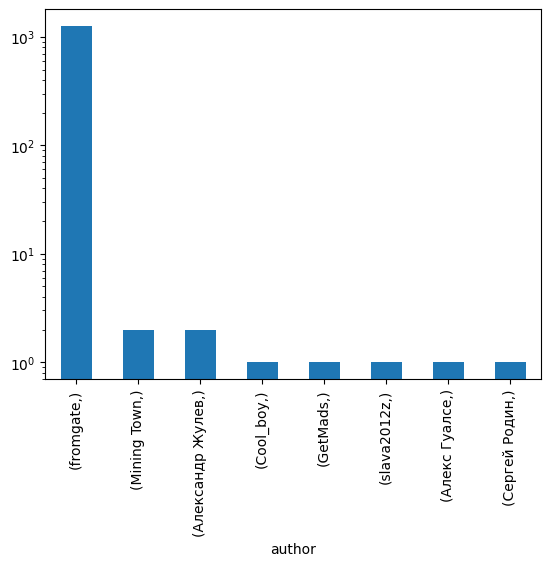

In [126]:
pd.read_sql_query('SELECT author FROM posts', con=con).value_counts().plot.bar()
plt.yscale('log')

In [36]:
pd.read_sql_query('SELECT * FROM tags', con=con)

,post_id,tag
0,1,minecraft.com
1,1,сайт
2,2,Minecraft 1.19
3,2,Minecraft 1.20
4,2,Minecraft Java Edition
...,...,...
3486,1265,Нотч
3487,1265,продажа Mojang
3488,1266,bukkit
3489,1266,BukkitDev


In [37]:
pd.read_sql_query('SELECT * FROM comments', con=con)

,id,post_id,author,pub_datetime,text,likes,dislikes
0,1,6,Felix14_v2,2022-10-19T19:06:48+03:00,Fromgate: Наборы ресурсов Также Fromgate: *рес...,2,
1,2,6,fromgate,2022-10-22T12:05:05+03:00,И?,,
2,3,6,QweSteR,2022-10-24T17:24:01+03:00,Как эти новые блоки получить?,,
3,4,7,Продукт мясокомбината,2022-10-16T07:54:46+03:00,"Всё, мы дошли до точки невозврата. Хуже уже фи...",2,
4,5,7,podlodka,2022-10-17T22:42:31+03:00,Мне кажется игре ГГ с тех пор как на оптимизац...,,
...,...,...,...,...,...,...,...
6102,6103,1264,Аркадий Московский,2018-11-27T17:04:55+03:00,Будто это было только сегодня,3,1
6103,6104,1264,Romytch27,2021-06-02T15:57:23+03:00,"Некропост, но это не первая",1,1
6104,6105,1265,Сергей,2018-01-26T04:24:06+03:00,"Надо было не уходит, Нотч…",1,
6105,6106,1265,Киров_1885,2020-12-26T14:25:21+03:00,А что так?,1,


## tf-idf

see my previous hw

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), min_df=2)

we'll do it with pandas

In [41]:
articles = pd.read_sql_query('SELECT id, title, full_text FROM posts', con=con)

lemmatizing

In [66]:
def ltz(text):
    return ' '.join((word for word in m.lemmatize(text) if any(letter.isalnum() for letter in word) and word not in sw)) + '\n'

In [68]:
articles['full_text'] = articles['full_text'].apply(ltz)

creating tf-idf matrix

In [42]:
t_matrix = tfidf.fit_transform(articles['full_text'])

getting top instances for a matrix row

In [44]:
def top_words(vector, feature_names, top_n=5):
    sorted_nzs = argsort(vector.data)[:-(top_n+1):-1]
    return feature_names[vector.indices[sorted_nzs]]

writing keywords to a new column

In [69]:
articles['keywords'] = articles.apply(lambda row: top_words(t_matrix[row.name, :], array(tfidf.get_feature_names_out())), axis=1)

here it is

In [63]:
articles

,id,title,full_text,keywords
0,1,Minecraft забрал себе домен minecraft.com,Если вы когда-то ошибались при вводе официаль...,"[minecraft com, адреса, домена, сайт, компания]"
1,2,"Обновление Minecraft 1.19.3, снапшот 22w46a",Выпущен новый снапшот Minecraft Java Editon...,"[пиглина, голова, пиглины, нотный блок то, на ..."
2,3,"Обновление Minecraft 1.19.3, снапшот 22w45a",Выпущен новый снапшот Minecraft Java Editio...,"[бамбука, вредины, по умолчанию, умолчанию, оп..."
3,4,"Обновление Minecraft 1.19.3, снапшот 22w44a",Разработчики во всю взялись за выпуск новых...,"[призыва, яйца призыва, яйца, изменения, расса..."
4,5,Разработчики Minecraft ответили на вопросы игр...,Обычно Minecraft Live сопровождается ответами...,"[мы, верблюдов, чтобы, бы, то]"
...,...,...,...,...
1261,1262,Евгеха остался без проекта!,Евгеха — один из самых популярных в мире русс...,"[проекта, совладельцем, оправдаться, продан, б..."
1262,1263,Краеугольный эндский камень или Трудности пере...,Почему у нас два разных перевода Minecraft? ...,"[перевода, перевод, end, вики, слова]"
1263,1264,Мировой рекорд — марафон по игре в Minecraft,Я уже писал о скоростном прохождении Майнкраф...,"[минут, перерыв, мировой рекорд, пальцы, мировой]"
1264,1265,Notch: Я покидаю Mojang,Перевод открытого письма Маркуса Пёрсона (Not...,"[что, не, символом, не хочу, то]"


## cosine similarity

getting a text-to-text cosine-similarity matrix

In [73]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(t_matrix)

retrieving most similar articles except for the article itself

In [96]:
def cos_most_similar(num):
    return [articles.loc[i, 'full_text'] for i in cos_sim[num].argsort()[-2:-5:-1]]

writing to a new column

In [97]:
articles['most_similar'] = articles.apply(lambda row: cos_most_similar(row.name), axis=1)

the whole frame. no sql this time

In [98]:
articles

,id,title,full_text,keywords,most_similar
0,1,Minecraft забрал себе домен minecraft.com,когда-то ошибаться ввод официальный адрес сайт...,"[minecraft com, адреса, домена, сайт, компания]",[получаться внимание привлекать ситуация проис...
1,2,"Обновление Minecraft 1.19.3, снапшот 22w46a",выпускать новый снапшот Minecraft Java Editon ...,"[пиглина, голова, пиглины, нотный блок то, на ...",[выпускать новый снапшот Minecraft Java Editio...
2,3,"Обновление Minecraft 1.19.3, снапшот 22w45a",выпускать новый снапшот Minecraft Java Edition...,"[бамбука, вредины, по умолчанию, умолчанию, оп...",[выпускать новый снапшот Minecraft Java Editon...
3,4,"Обновление Minecraft 1.19.3, снапшот 22w44a",разработчик весь взяться выпуск новый снапшот ...,"[призыва, яйца призыва, яйца, изменения, расса...",[снапшот выпускать среда самый хороший новое M...
4,5,Разработчики Minecraft ответили на вопросы игр...,обычно Minecraft Live сопровождаться ответ воп...,"[мы, верблюдов, чтобы, бы, то]",[Minecon 2018 завершение основной часть шоу по...
...,...,...,...,...,...
1261,1262,Евгеха остался без проекта!,евгеха самый популярный мир русскоязычный майн...,"[проекта, совладельцем, оправдаться, продан, б...",[получаться внимание привлекать ситуация проис...
1262,1263,Краеугольный эндский камень или Трудности пере...,почему разный перевод Minecraft Minecraft уник...,"[перевода, перевод, end, вики, слова]",[это очередной статья серия блок неделя посвящ...
1263,1264,Мировой рекорд — марафон по игре в Minecraft,писать скоростной прохождение майнкрафт сегодн...,"[минут, перерыв, мировой рекорд, пальцы, мировой]",[рассказывать непростой искусство играть Minec...
1264,1265,Notch: Я покидаю Mojang,перевод открытый письмо маркус персона Notch к...,"[что, не, символом, не хочу, то]",[главный разработчик Minecraft рассказывать но...


### examples

In [102]:
def print_sim(i):
    print(articles.loc[i, 'title'])
    for a in articles.loc[i, 'most_similar']:
        print(a[:1000])

In [103]:
print_sim(0)

Minecraft забрал себе домен minecraft.com
получаться внимание привлекать ситуация происходить ВК владелец пиратский проект лаунчер игра Minecraft легализоваться вид офшорный компания зарегистрировать товарный марка свой почему кавычка становиться понятно поздно программный продукт становиться бороться группа ВК сайт который распространяться продукт схожий название вопрос ответ событие вызывать очень вопрос попытаться находить ответ обращаться вопрос TLauncher Inc сначала электронный почта сделать это публично ответ последовать считать небольшой препирательство комментарий наш группа ВК некто обозначать друг админ TLauncher обвинять предвзятость из-за который никакой ответ получать интересно получать ответ вопрос рад опубликовывать вид отдельный интервью оставаться собирать факт попытаться находить ответ вопрос самостоятельно знакомый процесс написание статья сталкиваться группа лицо который становиться объект исследование существовать множество сайт проект судя несколько имя обращение 

In [104]:
print_sim(10)

Обновление Minecraft 1.19.1, снапшот 22w24a
Mojang следить постройка вдохновлять последний обновление игра автор RealzLlamaz Reddit Minecraft 1.19 1 добавлять жалоба из-за версия называть 1.19 84 распространять пугалка игра мочь забанить капс писать текст заглавный буква взгляд это преувеличение вероятность бан капс вернуться пока давать разбираться бывать жалоба грозить бывать жалоба Minecraft первый очередь нужно понимать пожаловаться игрок мочь действие чат кто-то чат обижать мочь пожаловаться модератор Minecraft мочь принимать мера заблокировать обидчик сетевой игра временно навечно это никакой разница играть локальный сервер друг популярный Hypixel Realms пожаловаться мочь везде некоторый исключение это поздно пожаловаться игрок список игрок который открываться меню режим пауза кнопка жалоба подача жалоба нужно выбирать игрок указывать возможный нарушение выбирать сообщение который прикладывать жалоба описывать именно происходить перечень причина который мочь повод жалоба распрост

In [105]:
print_sim(1000)

В Minecraft PE появились плащи!
попробовать создавать свой набор скин решать свой скин плащ моральный точка зрение иметь полный право поскольку получать свой плащ переводчик игра естественно додумываться плащ сразу появляться множество ресурспаков плащ поэтому выходить сегодня четвертый бета-версия плащ скин отключать проверять несколько набор скин который плащ отлично отображаться выход бета-версия результат примечательно плащ набор скин посвящать Minecon 2016 оставаться интересно мочь просто изменяться формат желание вернуть свой плащ обратно вряд плащ эксклюзивный вещь который раздавать мочь разработчик особый случай поэтому неудивительный возможность отображение плащ отключать интересно значить политика связывать плащ Minecraft Java Edition распространяться Minecraft

писать Minecraft 1.2 обнаруживаться возможность создавать скин модель естественно среди создатель скин находиться возможность очень приглянуться удовольствие представлять небольшой обзор получаться хэллоуинский скин п

## selenium

stolen.

In [ ]:
from selenium import webdriver
import time


browser=webdriver.Chrome()

last_height = browser.execute_script("return document.body.scrollHeight")
browser.get("https://openedu.ru/course/")
while True:
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight, {behavior: 'smooth'});")
    time.sleep(0.5)
    new_height = browser.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height
browser.close()